In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt

# Dataset Overview

Dataset

https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset?select=covid_19_data.csv

(This is a Kaggle Dataset version of John hopkins University data only)

The dataset is extracted for India. 
The time period of training data is from 30/01/2020 to 10/05/2020, and
the test data from the time period 11/05/2020 to 31/05/2020

In [32]:
df=pd.read_csv('https://github.com/ajtheb/Epidemic-forecasting-COVID-/raw/master/dataset/time_series_covid_india.csv')
df.head()

,Date,Cases
0,1/30/20,1
1,1/31/20,1
2,2/1/20,1
3,2/2/20,2
4,2/3/20,3


In [26]:
df.head(10)['Cases']

0    1
1    1
2    1
3    2
4    3
5    3
6    3
7    3
8    3
9    3
Name: Cases, dtype: int64

In [ ]:
df.tail()

,Date,Cases
97,5/6/20,52987
98,5/7/20,56351
99,5/8/20,59695
100,5/9/20,62808
101,5/10/20,67161


We have 102 rows and 2 columns.

Columns-

1. Date: Date of Observation

2. Cases: Cummulative Confirmed Cases 

In [ ]:
df.shape

(102, 1)

Test dataset

Test set consists of 21 rows form 5 may 2020.

In [33]:
dt=pd.read_csv('https://github.com/ajtheb/Epidemic-forecasting-COVID-/raw/master/dataset/test_time_series_covid_india.csv')
dt.head()

,Date,Cases
0,5/11/20,70768
1,5/12/20,74292
2,5/13/20,78055
3,5/14/20,81997
4,5/15/20,85784


In [ ]:
dat=dt['Date']

In [ ]:
dt.shape

(21, 2)

Plot between Day and number of Cases(Cumulative)

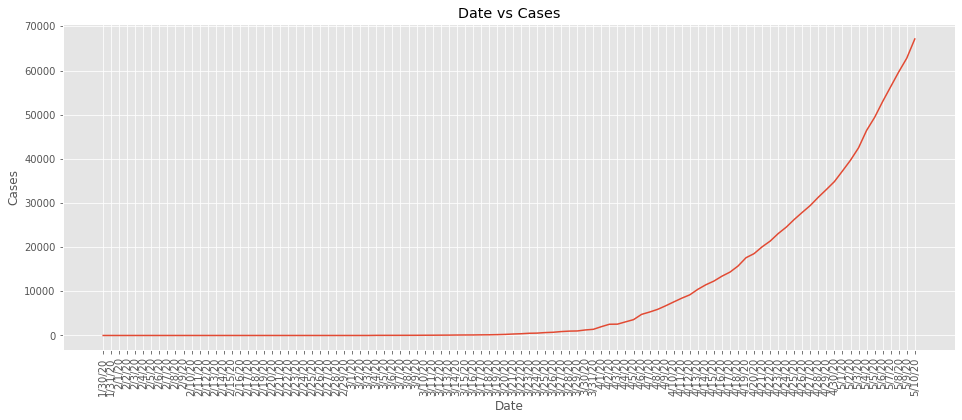

In [22]:
plt.figure(figsize=(16,6))
plt.style.use('ggplot')
plt.xticks(rotation=90)
plt.title("Date vs Cases")
plt.xlabel('Date')
plt.ylabel('Cases')
plt.plot(df['Date'],df['Cases'])

# Data Preparation

In [34]:
df.head()
df.drop('Date',axis=1,inplace=True)
dt.head()
dt.drop('Date',axis=1,inplace=True)

Scaling the data between 0 and 1 using MinMax Scaler.

In [35]:
from sklearn.preprocessing import MinMaxScaler
values=df.values
test_values=dt.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)           # Fit to data, then transform it.
scaled_test=scaler.transform(test_values)

In [36]:
 # convert series to supervised learning introducing lag in the dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

I tried for 1,2,3 and 4 timesteps and worked best for 2.

In [7]:
# frame as supervised learning
n_steps=2
reframed = series_to_supervised(scaled, 1, n_steps)
reframed_test=series_to_supervised(scaled_test, 1, n_steps)
#reframed.drop(reframed.columns[range(4,6)],axis=1,inplace=True)
reframed.head()

,var1(t-1),var1(t),var1(t+1)
1,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000015
3,0.000000,0.000015,0.000030
4,0.000015,0.000030,0.000030
5,0.000030,0.000030,0.000030


var(t+1) is the cases on (t+1)th day which is target and the var(t) and var(t-1) are cases on previous 2 days.

In [8]:
# target column
y_test=reframed_test['var1(t+1)']
reframed_test.drop('var1(t+1)',axis=1,inplace=True)

# Standard Vanilla LSTM

In [ ]:
# split into train and test sets(68:32 ratio)
values = reframed.values
testdf_values=reframed_test.values
n_train_hours = int(len(values)*0.70)
train = values[:n_train_hours, :]

# split into input and outputs
train_X, train_y = values[:n_train_hours, :-1], values[:n_train_hours, -1]
test_X, test_y = values[n_train_hours:, :-1], values[n_train_hours:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
testdf_values=testdf_values.reshape((testdf_values.shape[0], 1, testdf_values.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(70, 1, 2) (70,) (30, 1, 2) (30,)


Epoch 1/400
35/35 [==============================] - 1s 10ms/step - loss: 4.7713e-04 - val_loss: 0.2331
Epoch 2/400
35/35 [==============================] - 0s 3ms/step - loss: 3.9368e-04 - val_loss: 0.2188
Epoch 3/400
35/35 [==============================] - 0s 3ms/step - loss: 4.4060e-04 - val_loss: 0.2034
Epoch 4/400
35/35 [==============================] - 0s 3ms/step - loss: 3.5904e-04 - val_loss: 0.1859
Epoch 5/400
35/35 [==============================] - 0s 4ms/step - loss: 4.1256e-04 - val_loss: 0.1717
Epoch 6/400
35/35 [==============================] - 0s 3ms/step - loss: 4.3010e-04 - val_loss: 0.1512
Epoch 7/400
35/35 [==============================] - 0s 3ms/step - loss: 4.9676e-04 - val_loss: 0.1321
Epoch 8/400
35/35 [==============================] - 0s 3ms/step - loss: 2.0414e-04 - val_loss: 0.1121
Epoch 9/400
35/35 [==============================] - 0s 4ms/step - loss: 2.7059e-04 - val_loss: 0.0909
Epoch 10/400
35/35 [==============================] - 0s 4ms/step - loss

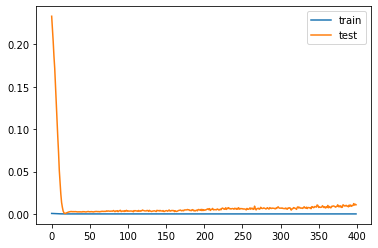

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.regularizers import l2
n_steps=2
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Dropout(0.7))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
history=model.fit(train_X, train_y, epochs=400,batch_size=2, validation_data=(test_X,test_y))
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
test_x.shape

(30, 2)

In [ ]:
testdf_value.shape

(19, 2)

In [ ]:
import keras
model=keras.models.load_model('/content/vanilla_lstm.h5')

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
pred1=model.predict(test_X)
yhat=pred1
#reshaping as the shape when scaling was done
test_x = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((test_x[:,:-1],yhat), axis=1)
print(inv_yhat.shape)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]
#reshaping as the shape when scaling was done
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_x[:,:-1],test_y), axis=1)
# invert scaling for actual
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

test_pred=model.predict(testdf_values)
testdf_value = testdf_values.reshape((testdf_values.shape[0], testdf_values.shape[2]))
test_pred = np.concatenate((testdf_value,test_pred), axis=1)
inv_test_pred=scaler.inverse_transform(test_pred)
inv_test_pred=inv_test_pred[:,-1]

test_pred = np.concatenate((testdf_value,np.array(y_test).reshape(-1,1)), axis=1)
inv_actual=scaler.inverse_transform(test_pred)
inv_actual=inv_actual[:,-1]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, np.round(inv_yhat)))
print('Test RMSE: %.3f' % rmse)
print("RMSLE",np.sqrt(mean_squared_log_error(inv_y, inv_yhat)))
pred_lstm=inv_yhat
test_pred_vanilla=inv_test_pred
print("RMSLE on unknown data",np.sqrt(mean_squared_log_error(inv_actual, inv_test_pred)))

(30, 2)
Test RMSE: 6977.739
RMSLE 0.11443694018858408
RMSLE on unknown data 0.5423555159817354


In [ ]:
model.save('vanilla_lstm.h5')

Plot between Predicted and Actual cases on validation dataset.

Text(0, 0.5, 'Cases')

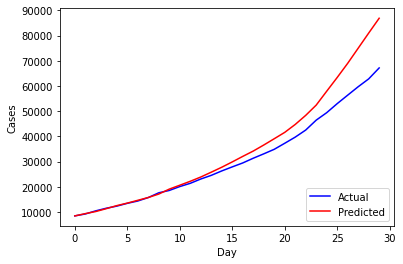

In [ ]:
plt.plot(range(len(inv_y)),inv_y,c='b')
plt.plot(range(len(inv_y)),pred_lstm,c='r')
plt.legend(["Actual", "Predicted"], loc ="lower right")
plt.xlabel('Day')
plt.ylabel('Cases')

Plot between Predicted and Actual cases on test dataset(unknown).

Text(0, 0.5, 'Cases')

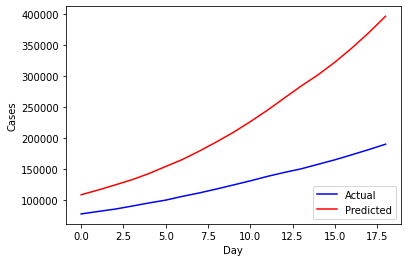

In [ ]:
plt.plot(range(len(y_test)),inv_actual,c='b')
plt.plot(range(len(y_test)),inv_test_pred,c='r')
plt.legend(["Actual", "Predicted"], loc ="lower right")
plt.xlabel('Day')
plt.ylabel('Cases')

# Bidirectional LSTM

In [14]:
# split into train and test sets(68:32 ratio)
values = reframed.values
testdf_values=reframed_test.values
n_train_hours = int(len(values)*0.70)
train = values[:n_train_hours, :]
# split into input and outputs
train_X, train_y = values[:n_train_hours, :-1], values[:n_train_hours, -1]
test_X, test_y = values[n_train_hours:, :-1], values[n_train_hours:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
testdf_values=testdf_values.reshape((testdf_values.shape[0], 1, testdf_values.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(70, 1, 2) (70,) (30, 1, 2) (30,)


Epoch 1/300
3/3 [==============================] - 3s 234ms/step - loss: 6.3798e-04 - val_loss: 0.2524
Epoch 2/300
3/3 [==============================] - 0s 30ms/step - loss: 5.1106e-04 - val_loss: 0.2427
Epoch 3/300
3/3 [==============================] - 0s 27ms/step - loss: 6.0033e-04 - val_loss: 0.2346
Epoch 4/300
3/3 [==============================] - 0s 25ms/step - loss: 4.1036e-04 - val_loss: 0.2290
Epoch 5/300
3/3 [==============================] - 0s 25ms/step - loss: 4.2535e-04 - val_loss: 0.2239
Epoch 6/300
3/3 [==============================] - 0s 26ms/step - loss: 5.2553e-04 - val_loss: 0.2196
Epoch 7/300
3/3 [==============================] - 0s 23ms/step - loss: 5.0947e-04 - val_loss: 0.2169
Epoch 8/300
3/3 [==============================] - 0s 23ms/step - loss: 5.1659e-04 - val_loss: 0.2154
Epoch 9/300
3/3 [==============================] - 0s 25ms/step - loss: 4.6384e-04 - val_loss: 0.2144
Epoch 10/300
3/3 [==============================] - 0s 28ms/step - loss: 5.1741e-

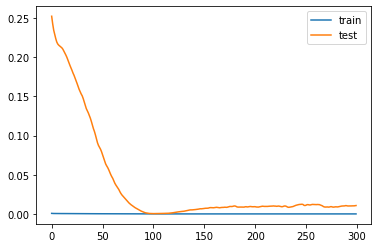

In [18]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.regularizers import l2
from keras.layers import Bidirectional
from keras.layers import Dropout
n_steps=1
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'),input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
history=model.fit(train_X, train_y, epochs=300 , validation_data=(test_X,test_y))
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
pred1=model.predict(test_X)
yhat=pred1
#reshaping as the shape when scaling was done
test_x = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((test_x[:,:-1],yhat), axis=1)
print(inv_yhat.shape)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]
#reshaping as the shape when scaling was done
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_x[:,:-1],test_y), axis=1)
# invert scaling for actual
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

test_pred=model.predict(testdf_values)
testdf_value = testdf_values.reshape((testdf_values.shape[0], testdf_values.shape[2]))
test_pred = np.concatenate((testdf_value,test_pred), axis=1)
inv_test_pred=scaler.inverse_transform(test_pred)
inv_test_pred=inv_test_pred[:,-1]

test_pred = np.concatenate((testdf_value,np.array(y_test).reshape(-1,1)), axis=1)
inv_actual=scaler.inverse_transform(test_pred)
inv_actual=inv_actual[:,-1]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, np.round(inv_yhat)))
print('Test RMSE: %.3f' % rmse)
print("RMSLE",np.sqrt(mean_squared_log_error(inv_y, inv_yhat)))
pred_bi=inv_yhat
print("RMSLE on unknown data ",np.sqrt(mean_squared_log_error(inv_actual, inv_test_pred)))
test_pred_bi=inv_test_pred

(30, 2)
Test RMSE: 6944.493
RMSLE 0.13445299159788268
RMSLE on unknown data  0.4114650871122174


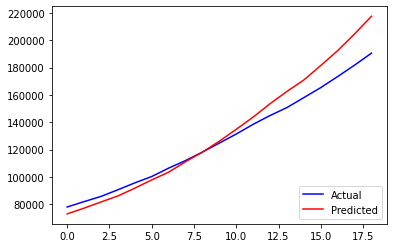

In [ ]:
plt.plot(range(len(y_test)),inv_actual,c='b')
plt.plot(range(len(y_test)),inv_test_pred,c='r')
plt.legend(["Actual", "Predicted"], loc ="lower right")

# CNN LSTM

In [11]:
# split into train and test sets(68:32 ratio)
values = reframed.values
testdf_values=reframed_test.values
n_train_hours = int(len(values)*0.70)
train = values[:n_train_hours, :]
# split into input and outputs
train_X, train_y = values[:n_train_hours, :-1], values[:n_train_hours, -1]
test_X, test_y = values[n_train_hours:, :-1], values[n_train_hours:, -1]
# reshape input to be 3D [samples, timesteps, features]

# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
n_features = 1
n_seq = 1
n_steps = 2
#X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))
train_X = train_X.reshape((train_X.shape[0], n_seq, n_steps, n_features))
test_X = test_X.reshape((test_X.shape[0],n_seq,n_steps, n_features))
testdf_values=testdf_values.reshape((testdf_values.shape[0], n_seq,n_steps, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(70, 1, 2, 1) (70,) (30, 1, 2, 1) (30,)


Epoch 1/500
3/3 [==============================] - 2s 175ms/step - loss: 6.0902e-04 - val_loss: 0.2675
Epoch 2/500
3/3 [==============================] - 0s 26ms/step - loss: 5.3409e-04 - val_loss: 0.2565
Epoch 3/500
3/3 [==============================] - 0s 26ms/step - loss: 6.5177e-04 - val_loss: 0.2480
Epoch 4/500
3/3 [==============================] - 0s 24ms/step - loss: 5.3491e-04 - val_loss: 0.2423
Epoch 5/500
3/3 [==============================] - 0s 27ms/step - loss: 4.8981e-04 - val_loss: 0.2380
Epoch 6/500
3/3 [==============================] - 0s 25ms/step - loss: 4.4938e-04 - val_loss: 0.2352
Epoch 7/500
3/3 [==============================] - 0s 23ms/step - loss: 5.3223e-04 - val_loss: 0.2328
Epoch 8/500
3/3 [==============================] - 0s 24ms/step - loss: 4.7296e-04 - val_loss: 0.2306
Epoch 9/500
3/3 [==============================] - 0s 31ms/step - loss: 5.8280e-04 - val_loss: 0.2285
Epoch 10/500
3/3 [==============================] - 0s 27ms/step - loss: 5.3400e-

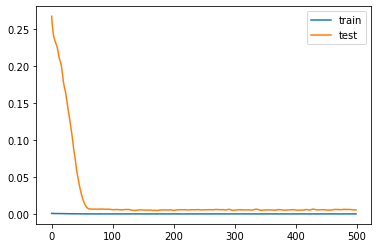

In [12]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.regularizers import l2
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers import ConvLSTM2D
from keras.layers.convolutional import MaxPooling1D
#train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
#test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2,padding='same')))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
history=model.fit(train_X, train_y, epochs=500, validation_data=(test_X,test_y))
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
pred1=model.predict(test_X)
yhat=pred1
#reshaping as the shape when scaling was done
test_x = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((test_x[:,:-1],yhat), axis=1)
print(inv_yhat.shape)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]
#reshaping as the shape when scaling was done
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_x[:,:-1],test_y), axis=1)
# invert scaling for actual
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

test_pred=model.predict(testdf_values)
testdf_value = testdf_values.reshape((testdf_values.shape[0], testdf_values.shape[2]))
test_pred = np.concatenate((testdf_value,test_pred), axis=1)
inv_test_pred=scaler.inverse_transform(test_pred)
inv_test_pred=inv_test_pred[:,-1]

test_pred = np.concatenate((testdf_value,np.array(y_test).reshape(-1,1)), axis=1)
inv_actual=scaler.inverse_transform(test_pred)
inv_actual=inv_actual[:,-1]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, np.round(inv_yhat)))
print('Test RMSE: %.3f' % rmse)
print("RMSLE",np.sqrt(mean_squared_log_error(inv_y, inv_yhat)))
pred_cnn=inv_yhat
print("RMSLE",np.sqrt(mean_squared_log_error(inv_actual, inv_test_pred)))
test_pred_cnn=inv_test_pred

(30, 2)
Test RMSE: 4955.171
RMSLE 0.15369106488579096
RMSLE 0.12552539882815636


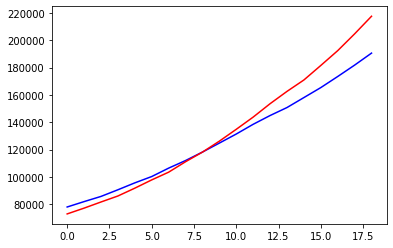

In [ ]:
plt.plot(range(len(y_test)),inv_actual,c='b')
plt.plot(range(len(y_test)),inv_test_pred,c='r')

# Stacked CNN + Bidirectional LSTM

In [96]:
# split into train and test sets(68:32 ratio)
values = reframed.values
testdf_values=reframed_test.values
n_train_hours = int(len(values)*0.70)
train = values[:n_train_hours, :]
# split into input and outputs
train_X, train_y = values[:n_train_hours, :-1], values[:n_train_hours, -1]
test_X, test_y = values[n_train_hours:, :-1], values[n_train_hours:, -1]
# reshape input to be 3D [samples, timesteps, features]

# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
n_features = 1
n_seq = 1
n_steps = 2
#X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))
train_X = train_X.reshape((train_X.shape[0], n_seq, n_steps, n_features))
test_X = test_X.reshape((test_X.shape[0],n_seq,n_steps, n_features))
testdf_values=testdf_values.reshape((testdf_values.shape[0], n_seq,n_steps, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(70, 1, 2, 1) (70,) (30, 1, 2, 1) (30,)


Epoch 1/200
3/3 [==============================] - 3s 368ms/step - loss: 6.7868e-04 - val_loss: 0.2606
Epoch 2/200
3/3 [==============================] - 0s 26ms/step - loss: 5.0353e-04 - val_loss: 0.2529
Epoch 3/200
3/3 [==============================] - 0s 27ms/step - loss: 5.0182e-04 - val_loss: 0.2460
Epoch 4/200
3/3 [==============================] - 0s 27ms/step - loss: 5.7618e-04 - val_loss: 0.2405
Epoch 5/200
3/3 [==============================] - 0s 26ms/step - loss: 5.6554e-04 - val_loss: 0.2369
Epoch 6/200
3/3 [==============================] - 0s 26ms/step - loss: 5.0738e-04 - val_loss: 0.2354
Epoch 7/200
3/3 [==============================] - 0s 25ms/step - loss: 6.3638e-04 - val_loss: 0.2330
Epoch 8/200
3/3 [==============================] - 0s 29ms/step - loss: 4.5886e-04 - val_loss: 0.2308
Epoch 9/200
3/3 [==============================] - 0s 25ms/step - loss: 4.4936e-04 - val_loss: 0.2284
Epoch 10/200
3/3 [==============================] - 0s 26ms/step - loss: 5.5536e-

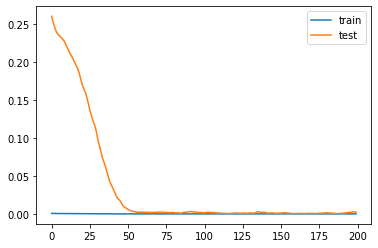

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.regularizers import l2
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers import ConvLSTM2D
from keras.layers import Dropout
from keras.layers.convolutional import MaxPooling1D
#train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
#test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2,padding='valid')))
model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(50, activation='relu')))
#model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
history=model.fit(train_X, train_y, epochs=200, validation_data=(test_X,test_y))
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [97]:
import keras 
model=keras.models.load_model('/content/cnn_bidirectional_lstm (1).h5')

In [102]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
pred1=model.predict(test_X)
yhat=pred1
#reshaping as the shape when scaling was done
test_x = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((test_x[:,:-1],yhat), axis=1)
print(inv_yhat.shape)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]
#reshaping as the shape when scaling was done
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_x[:,:-1],test_y), axis=1)
# invert scaling for actual
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

test_pred=model.predict(testdf_values)
testdf_value = testdf_values.reshape((testdf_values.shape[0], testdf_values.shape[2]))
test_pred = np.concatenate((testdf_value,test_pred), axis=1)
inv_test_pred=scaler.inverse_transform(test_pred)
inv_test_pred=inv_test_pred[:,-1]

test_pred = np.concatenate((testdf_value,np.array(y_test).reshape(-1,1)), axis=1)
inv_actual=scaler.inverse_transform(test_pred)
inv_actual=inv_actual[:,-1]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, np.round(inv_yhat)))
print('Test RMSE: %.3f' % rmse)
print("RMSLE",np.sqrt(mean_squared_log_error(inv_y, inv_yhat)))
pred_st=inv_yhat
rmsle_st=np.sqrt(mean_squared_log_error(inv_actual, inv_test_pred))
print("RMSLE on unknown data",rmsle_st)
test_pred_st=inv_test_pred

(30, 2)
Test RMSE: 417.012
RMSLE 0.014806429422458533
RMSLE on unknown data 0.009253714563155832


LSTM training results are stochastic as it take different initial weights in each run,so i saved the best model.

In [ ]:
model.save('cnn_bidirectional_lstm.h5')

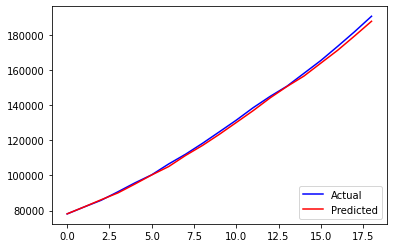

In [103]:
plt.plot(range(len(y_test)),inv_actual,c='b')
plt.plot(range(len(y_test)),inv_test_pred,c='r')
plt.legend(["Actual", "Predicted"], loc ="lower right")

Tried Ensemble of models but didnt work out well.

In [ ]:
from sklearn.metrics import mean_squared_log_error
p=(0.2*np.array(pred_bi)+0.2*(np.array(pred_cnn))+0.6*np.array(pred_st))
print("RMSLE",np.sqrt(mean_squared_log_error(inv_y,p)))

RMSLE 0.034116215566124014


In [ ]:
from sklearn.metrics import mean_squared_log_error
p=(0.3*np.array(test_pred_vanilla)+0.1*np.array(test_pred_bi)+0.2*np.array(test_pred_cnn)+0.4*np.array(test_pred_st))
print("RMSLE",np.sqrt(mean_squared_log_error(y_test,p)))

RMSLE 9.747862735811061


# Results

In [ ]:
pd.DataFrame({"Date":dat.values[2:],"Standard Vanilla LSTM ":test_pred_vanilla,"Bidirectional":test_pred_bi,"CNN LSTM":test_pred_cnn,"Stacked CNN and Bidirecctional":test_pred_st,"Actual":inv_actual})

,Date,Standard Vanilla LSTM,Bidirectional,CNN LSTM,Stacked CNN and Bidirecctional,Actual
0,5/13/20,108997.038194,72991.831628,72991.831628,78118.767305,78055.0
1,5/14/20,116581.909357,77219.498597,77219.498597,82014.549576,81997.0
2,5/15/20,124805.138570,81715.017510,81715.017510,86092.110253,85784.0
3,5/16/20,133202.508374,86098.018752,86098.018752,90005.826179,90648.0
4,5/17/20,143145.719191,91819.679256,91819.679256,95027.289549,95698.0
5,5/18/20,154640.215164,97869.501625,97869.501625,100234.262167,100328.0
6,5/19/20,166055.851093,103513.743182,103513.743182,105002.100426,106475.0
7,5/20/20,179632.332302,111150.878139,111150.878139,111322.745000,112028.0
8,5/21/20,194265.922400,118190.101844,118190.101844,117023.053246,118226.0
9,5/22/20,209730.705372,126202.946869,126202.946869,123374.281107,124794.0


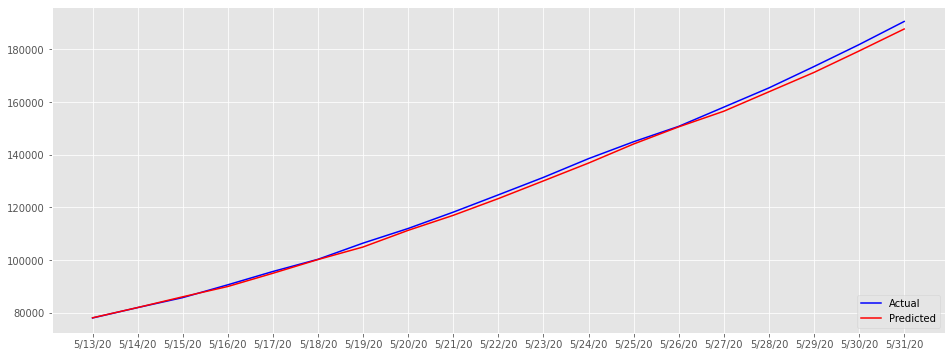

In [108]:
# Prediciton using Stacked model
plt.style.use('ggplot')
plt.figure(figsize=(16,6))
plt.plot(dat.values[2:],inv_actual,c='b')
plt.plot(dat.values[2:],inv_test_pred,c='r')
plt.legend(["Actual", "Predicted"], loc ="lower right")

In [111]:
print('Test RMSE: %.3f' % rmse)
print("RMSLE for Stacked model : ",rmsle_st)

Test RMSE: 417.012
RMSLE for Stacked model :  0.009253714563155832


better than rmsle 1.52 and 1.75 of SEIR and Regression. 